In [1]:
import pandas as pd

data = pd.read_csv('train.csv')
data[2010:].head(10)

,id,keyword,location,text,target
2010,2886,damage,NaN,Beach did damage to my shit,1
2011,2887,damage,NaN,@WonderousAllure crosses her arms to cover her...,0
2012,2888,damage,NaN,New post on my blog: http://t.co/Avu9b4k2rv \n...,0
2013,2889,damage,Charlotte NC,REPORTED: HIT &amp; RUN-IN ROADWAY-PROPERTY DA...,1
2014,2890,damage,NaN,Devil May Cry 4 Special Edition Vergil Vs Agnu...,0
2015,2891,damage,"Rockville, Maryland",#Glaucoma occurs when fluid builds up pressure...,1
2016,2893,damage,NaN,#JSunNews Storm damage reported in Madison Cou...,1
2017,2895,damage,NaN,S61.231A Puncture wound without foreign body o...,1
2018,2896,damage,Australia,Thank you @RicharkKirkArch @AusInstArchitect f...,0
2019,2898,damage,Your Conversation,This real shit will damage a bitch,0


In [2]:

# if location was specified --> 1, else --> 0
data['location'] = data['location'].notnull().astype(int)
data['location'] = data['location'].fillna(0)


data['text'] = data['text'].str.replace('http\S+', 'http', regex=True)  # replace all URLs with "http"
data['text'] = data['text'].str.replace('&\S+', '', regex=True)  # remove all html junks
data['text'] = data['text'].str.replace('[0-9]','0', regex=True)  # replace all integer valeus with 0
data['text'] = data['text'].str.replace('[^a-zA-Z0 ]', '', regex=True)
data['text'] = data['text'].str.lower()
data[2010:].head(10)

,id,keyword,location,text,target
2010,2886,damage,0,beach did damage to my shit,1
2011,2887,damage,0,wonderousallure crosses her arms to cover her ...,0
2012,2888,damage,0,new post on my blog http thesensualeyemodel ca...,0
2013,2889,damage,1,reported hit runin roadwayproperty damage at ...,1
2014,2890,damage,0,devil may cry 0 special edition vergil vs agnu...,0
2015,2891,damage,1,glaucoma occurs when fluid builds up pressure ...,1
2016,2893,damage,0,jsunnews storm damage reported in madison coun...,1
2017,2895,damage,0,s00000a puncture wound without foreign body of...,1
2018,2896,damage,1,thank you richarkkirkarch ausinstarchitect for...,0
2019,2898,damage,1,this real shit will damage a bitch,0


In [3]:
config = {
    'token_num_words' : 10000,
    'embedding_dim' : 32,
    'sent_max_len' : 30,
    'key_embedding_dim' : 8,
}

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=config['token_num_words'], oov_token='<OOV>')
tokenizer.fit_on_texts(data['text'])
list(tokenizer.word_index.keys())[:10]

['<OOV>', 'http', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

In [5]:
text_seq = tokenizer.texts_to_sequences(data['text'])  # convert text to numerics
data.insert(4, 'text_seq', text_seq)

data['keyword'] = pd.Categorical(data['keyword']).codes  # change keyword from string to numerics
data['keyword'] += 1
key_num_words = data['keyword'].nunique()

data[2010:].head(10)

,id,keyword,location,text,text_seq,target
2010,2886,58,0,beach did damage to my shit,"[860, 149, 225, 6, 14, 210]",1
2011,2887,58,0,wonderousallure crosses her arms to cover her ...,"[9488, 3860, 81, 2153, 6, 1269, 81, 1730, 23, ...",0
2012,2888,58,0,new post on my blog http thesensualeyemodel ca...,"[53, 356, 12, 14, 1699, 2, 9490, 3862, 9491, 9...",0
2013,2889,58,1,reported hit runin roadwayproperty damage at ...,"[975, 228, 9495, 9496, 225, 20, 260, 9497, 817]",1
2014,2890,58,0,devil may cry 0 special edition vergil vs agnu...,"[5262, 129, 2223, 16, 1368, 2156, 9498, 906, 9...",0
2015,2891,58,1,glaucoma occurs when fluid builds up pressure ...,"[9502, 3864, 44, 5263, 4999, 30, 1601, 598, 91...",1
2016,2893,58,0,jsunnews storm damage reported in madison coun...,"[9506, 92, 225, 975, 5, 3865, 363, 267, 225, 9...",1
2017,2895,58,0,s00000a puncture wound without foreign body of...,"[9507, 5264, 3111, 236, 3866, 86, 7, 505, 9508...",1
2018,2896,58,1,thank you richarkkirkarch ausinstarchitect for...,"[504, 13, 9510, 9511, 11, 615, 7, 298, 416, 95...",0
2019,2898,58,1,this real shit will damage a bitch,"[22, 388, 210, 42, 225, 4, 1477]",0


In [6]:
data.dtypes

id           int64
keyword      int16
location     int32
text        object
text_seq    object
target       int64
dtype: object

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

seq_input = pad_sequences(data['text_seq'], maxlen=config['sent_max_len'], padding='post', truncating='post')
key_input = data['keyword'].to_numpy()
key_input = np.reshape(key_input, (key_input.shape[0], 1))
loc_input = data['location'].to_numpy()
loc_input = np.reshape(loc_input, (loc_input.shape[0], 1))

output = data['target'].to_numpy()

print("seq_input Shape: ", seq_input.shape)
print("key_input Shape: ", key_input.shape)
print("loc_input Shape: ", loc_input.shape)
print("output Shape: ", output.shape)

seq_input Shape:  (7613, 30)
key_input Shape:  (7613, 1)
loc_input Shape:  (7613, 1)
output Shape:  (7613,)


In [14]:
import tensorflow as tf

x_seq = tf.keras.layers.Input(shape=(config['sent_max_len']), name='seq_input')
x1 = tf.keras.layers.Embedding(config['token_num_words'], config['embedding_dim'])(x_seq)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x1)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x1)


x_key = tf.keras.layers.Input(shape=(1), name='key_input')
x2 = tf.keras.layers.Embedding(key_num_words, config['key_embedding_dim'])(x_key)
x2 = tf.keras.layers.Flatten()(x2)

x_loc = tf.keras.layers.Input(shape=(1), name='loc_input')

x = tf.keras.layers.Concatenate()([x1, x2, x_loc])
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

model = tf.keras.models.Model(inputs=[x_seq, x_key, x_loc], outputs=y)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 30, 32)       320000      seq_input[0][0]                  
__________________________________________________________________________________________________
key_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 30, 128)      49664       embedding_6[0][0]                
_______________________________________________________________________________________

In [15]:
history = model.fit(x={'seq_input':seq_input, 'key_input':key_input, 'loc_input':loc_input}, y=output, epochs=20, validation_split=0.1)

Epoch 1/20
215/215 [==============================] - 6s 26ms/step - loss: 0.6830 - accuracy: 0.5735 - val_loss: 0.6810 - val_accuracy: 0.5341
Epoch 2/20
215/215 [==============================] - 5s 21ms/step - loss: 0.5885 - accuracy: 0.6952 - val_loss: 0.4999 - val_accuracy: 0.7664
Epoch 3/20
215/215 [==============================] - 5s 21ms/step - loss: 0.4173 - accuracy: 0.8257 - val_loss: 0.4741 - val_accuracy: 0.7638
Epoch 4/20
215/215 [==============================] - 5s 21ms/step - loss: 0.3374 - accuracy: 0.8702 - val_loss: 0.4746 - val_accuracy: 0.7612
Epoch 5/20
215/215 [==============================] - 5s 21ms/step - loss: 0.2811 - accuracy: 0.8993 - val_loss: 0.4783 - val_accuracy: 0.7848
Epoch 6/20
215/215 [==============================] - 5s 21ms/step - loss: 0.2373 - accuracy: 0.9123 - val_loss: 0.5092 - val_accuracy: 0.7808
Epoch 7/20
215/215 [==============================] - 5s 21ms/step - loss: 0.2008 - accuracy: 0.9288 - val_loss: 0.6072 - val_accuracy: 0.7795

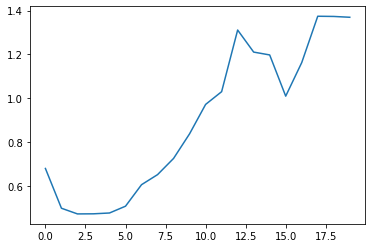

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'])

In [27]:
# rebuild the same model to reset weights

x_seq = tf.keras.layers.Input(shape=(config['sent_max_len']), name='seq_input')
x1 = tf.keras.layers.Embedding(config['token_num_words'], config['embedding_dim'])(x_seq)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x1)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x1)


x_key = tf.keras.layers.Input(shape=(1), name='key_input')
x2 = tf.keras.layers.Embedding(key_num_words, config['key_embedding_dim'])(x_key)
x2 = tf.keras.layers.Flatten()(x2)

x_loc = tf.keras.layers.Input(shape=(1), name='loc_input')

x = tf.keras.layers.Concatenate()([x1, x2, x_loc])
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

model = tf.keras.models.Model(inputs=[x_seq, x_key, x_loc], outputs=y)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 30, 32)       320000      seq_input[0][0]                  
__________________________________________________________________________________________________
key_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 30, 128)      49664       embedding_10[0][0]               
______________________________________________________________________________________

In [28]:
history = model.fit(x={'seq_input':seq_input, 'key_input':key_input, 'loc_input':loc_input}, y=output, epochs=5)

Epoch 1/7
238/238 [==============================] - 5s 22ms/step - loss: 0.6929 - accuracy: 0.5150
Epoch 2/7
238/238 [==============================] - 5s 21ms/step - loss: 0.6278 - accuracy: 0.6438
Epoch 3/7
238/238 [==============================] - 5s 21ms/step - loss: 0.4429 - accuracy: 0.8089
Epoch 4/7
238/238 [==============================] - 5s 21ms/step - loss: 0.3706 - accuracy: 0.8533
Epoch 5/7
238/238 [==============================] - 5s 23ms/step - loss: 0.3118 - accuracy: 0.8813
Epoch 6/7
238/238 [==============================] - 5s 21ms/step - loss: 0.2673 - accuracy: 0.9014
Epoch 7/7
238/238 [==============================] - 5s 21ms/step - loss: 0.2290 - accuracy: 0.9166


In [29]:
# Apply Preprocssing to Test Data

test_data = pd.read_csv('test.csv')
test_data['location'] = test_data['location'].notnull().astype(int)
test_data['location'] = test_data['location'].fillna(0)


test_data['text'] = test_data['text'].str.replace('http\S+', 'http', regex=True)
test_data['text'] = test_data['text'].str.replace('&\S+', '', regex=True)
test_data['text'] = test_data['text'].str.replace('[0-9]','0', regex=True)
test_data['text'] = test_data['text'].str.replace('[^a-zA-Z0 ]', '', regex=True)
test_data['text'] = test_data['text'].str.lower()

text_seq = tokenizer.texts_to_sequences(test_data['text'])
test_data.insert(4, 'text_seq', text_seq)

test_data['keyword'] = pd.Categorical(test_data['keyword']).codes
test_data['keyword'] += 1

seq_input_test = pad_sequences(test_data['text_seq'], maxlen=config['sent_max_len'], padding='post', truncating='post')
key_input_test = test_data['keyword'].to_numpy()
key_input_test = np.reshape(key_input_test, (key_input_test.shape[0], 1))
loc_input_test = test_data['location'].to_numpy()
loc_input_test = np.reshape(loc_input_test, (loc_input_test.shape[0], 1))

In [30]:
pred = model.predict(x={'seq_input':seq_input_test, 'key_input':key_input_test, 'loc_input':loc_input_test})
pred = np.asarray(np.rint(pred), dtype=int)
pred[:10]

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0]])

In [31]:
submission = pd.DataFrame()
submission['id'] = test_data['id']
submission['target'] = pred
submission.head(10)

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [32]:
submission.to_csv('submission.csv', index=False)